In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/Kaggle/class_number/train.csv')

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print('Number of training samples: {0}'.format(n_train))
print('Number of training pixels: {0}'.format(n_pixels))
print('Number of classes: {0}'.format(n_class))

FileNotFoundError: ignored

In [ ]:
train_df.shape()

NameError: ignored

In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/Kaggle/class_number/test.csv')

n_test = len(test_df)
n_pixels = len(test_df.columns)

print('Number of train samples: {0}'.format(n_test))
print('Number of test pixels: {0}'.format(n_pixels))

Number of train samples: 28000
Number of test pixels: 784


In [ ]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


1, 2, 2, 0, 9, 1, 0, 5


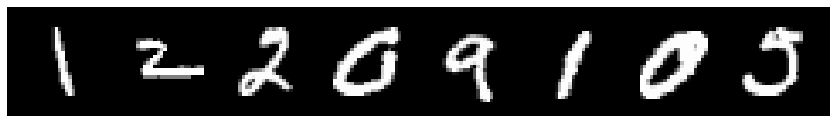

In [ ]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((train_df.iloc[random_sel, 1:].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

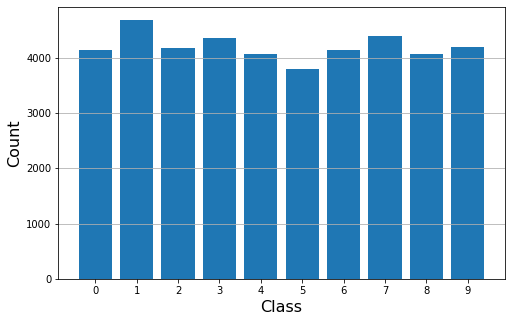

In [ ]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.bar(train_df['label'].value_counts().index, train_df['label'].value_counts())
plt.xticks(np.arange(n_class))
plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.grid("on", axis='y')


In [ ]:
train_df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [ ]:
class MNIST_data(Dataset):
  def __init__(self, file_path, transform = transforms.Compose([
                                      transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(0.5,))])):
    
    df = pd.read_csv(file_path)
    if len(df.columns) == n_pixels:
      # test data
      self.X = df.values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
      self.y = None
    else:
      # training data
      self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
      self.y = torch.from_numpy(df.iloc[:,0].values)
            
    self.transform = transform
    
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    if self.y is not None:
      return self.transform(self.X[idx]), self.y[idx]
    else:
      return self.transform(self.X[idx])


In [ ]:
class RandomRotation(object):
  def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

  @staticmethod
  def get_params(degrees):
    angle = np.random.uniform(degrees[0], degrees[1])
    return angle

  
  def __call__(self, img):
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)
        return rotate(img, angle, self.resample, self.expand, self.center)

In [ ]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        hshift, vshift = np.random.uniform(-shift, shift, size=2)
        return hshift, vshift 
    
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)

In [ ]:
batch_size = 64

train_dataset = MNIST_data('/content/drive/My Drive/Kaggle/class_number/train.csv', transform= transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))


test_dataset = MNIST_data('/content/drive/My Drive/Kaggle/class_number/test.csv')


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, shuffle=False)

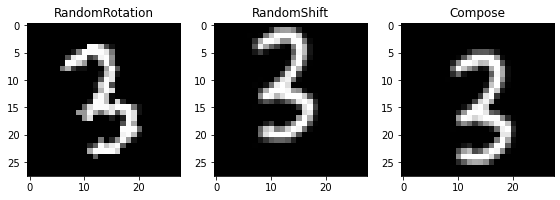

In [ ]:
rotate = RandomRotation(20)
shift = RandomShift(3)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Network Structure

In [ ]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.5)

            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [ ]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

## Training and Evaluation

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))

In [ ]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        
        data, target = data.to(device), target.to(device)

        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

In [ ]:
n_epochs = 2

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

Train Epoch: 0 [6400/42000 (15%)]	Loss: 13.391746
Train Epoch: 0 [12800/42000 (30%)]	Loss: 8.881974
Train Epoch: 0 [19200/42000 (46%)]	Loss: 5.689582
Train Epoch: 0 [25600/42000 (61%)]	Loss: 7.086659
Train Epoch: 0 [32000/42000 (76%)]	Loss: 5.648192
Train Epoch: 0 [38400/42000 (91%)]	Loss: 4.229152


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  import sys
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average loss: 1.0826, Accuracy: 31593/42000 (75.221%)

Train Epoch: 1 [6400/42000 (15%)]	Loss: 4.101484
Train Epoch: 1 [12800/42000 (30%)]	Loss: 2.742161
Train Epoch: 1 [19200/42000 (46%)]	Loss: 4.001890
Train Epoch: 1 [25600/42000 (61%)]	Loss: 2.862225
Train Epoch: 1 [32000/42000 (76%)]	Loss: 2.272849
Train Epoch: 1 [38400/42000 (91%)]	Loss: 2.332528

Average loss: 0.6144, Accuracy: 35434/42000 (84.367%)



In [ ]:
def prediction(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred


In [ ]:
test_pred = prediction(test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [ ]:
out_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [ ]:
out_df.head(8)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
5,6,7
6,7,0
7,8,3


(-0.5, 241.5, 31.5, -0.5)

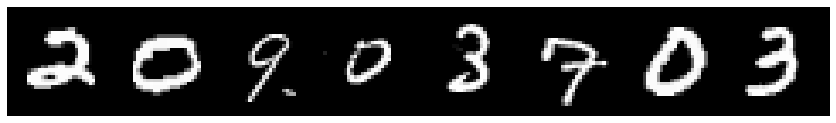

In [ ]:
random_sel = np.random.randint(n_train, size=8)

grid = make_grid(torch.Tensor((test_df.iloc[np.array(range(8)), :].values/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=8)
plt.rcParams['figure.figsize'] = (16, 2)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.axis('off')
# print(*list(test_df.iloc[np.array(range(8)), ].values), sep = ', ')

# RNN

In [ ]:
from torchvision import transforms

In [ ]:
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose([transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
trainset.data.size()

torch.Size([60000, 28, 28])

In [ ]:
testset.data.size()

torch.Size([10000, 28, 28])

In [ ]:
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        # print(X.size())
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
# print(images.size())
model = ImageRNN(BATCH_SIZE, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[-0.0049,  0.0982, -0.0960,  0.0255, -0.0352,  0.0749,  0.1631,  0.0127,
          0.0433,  0.0103],
        [ 0.0029,  0.0914, -0.1024,  0.0004, -0.0521,  0.0839,  0.1585, -0.0095,
          0.0568,  0.0283],
        [ 0.0016,  0.0957, -0.1075,  0.0116, -0.0584,  0.0795,  0.1717, -0.0095,
          0.0534,  0.0295],
        [-0.0090,  0.1097, -0.0953,  0.0049, -0.0576,  0.0728,  0.1120, -0.0385,
          0.0581,  0.0157],
        [-0.0020,  0.0832, -0.1046,  0.0101, -0.0484,  0.0819,  0.1482, -0.0197,
          0.0497,  0.0253],
        [-0.0053,  0.0895, -0.1124,  0.0229, -0.0536,  0.0864,  0.2029, -0.0079,
          0.0422,  0.0267],
        [ 0.0012,  0.0885, -0.1115,  0.0078, -0.0608,  0.0769,  0.1509, -0.0202,
          0.0412,  0.0173],
        [-0.0029,  0.0963, -0.1072,  0.0025, -0.0549,  0.0835,  0.1546, -0.0120,
          0.0530,  0.0255],
        [ 0.0003,  0.0933, -0.1044, -0.0006, -0.0511,  0.0824,  0.1545, -0.0158,
          0.0528,  0.0243],
        [ 0.0066,  

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7452 | Train Accuracy: 75.52
Epoch:  1 | Loss: 0.3282 | Train Accuracy: 90.37
Epoch:  2 | Loss: 0.2466 | Train Accuracy: 92.92
Epoch:  3 | Loss: 0.1992 | Train Accuracy: 94.38
Epoch:  4 | Loss: 0.1793 | Train Accuracy: 94.95
Epoch:  5 | Loss: 0.1624 | Train Accuracy: 95.48
Epoch:  6 | Loss: 0.1493 | Train Accuracy: 95.85
Epoch:  7 | Loss: 0.1441 | Train Accuracy: 95.89
Epoch:  8 | Loss: 0.1350 | Train Accuracy: 96.23
Epoch:  9 | Loss: 0.1224 | Train Accuracy: 96.59


In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)
    # print(labels)
    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.19
